In [1]:
%matplotlib inline
import os, sys
import torch
import configargparse
import numpy as np
import matplotlib.pyplot as plt
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../src/experiment_scripts'))
if module_path not in sys.path:
    sys.path.append(module_path)
from aNiMAte.src.experiment_scripts.main import init_config
from aNiMAte.src.atomic_utils import AtomicModel
from aNiMAte.src.dynamics_utils import DynamicsModelNMA
from aNiMAte.src.prody_utils import read_prody_model, write_prody_model
import pykeops

##### Set the SLURM job IDs here ####
M1_JOB_ID = '7992273'
M2_JOB_ID = '8007570'
FULL_JOB_ID = '8019309' # Can also be set to None

#### Should not need to change the following lines ####
M1_EVAL_PATH = f'../logs/{M1_JOB_ID}/eval'
M2_EVAL_PATH = f'../logs/{M2_JOB_ID}/eval'
FULL_EVAL_PATH = f'../logs/{FULL_JOB_ID}/eval' if FULL_JOB_ID is not None else None
M1_CONFIG_PATH =  f'../logs/{M1_JOB_ID}_0/config.ini'
M2_CONFIG_PATH =  f'../logs/{M2_JOB_ID}_0/config.ini'
FULL_CONFIG_PATH =  f'../logs/{FULL_JOB_ID}_0/config.ini'if FULL_JOB_ID is not None else None

def getDynamicModel(config_path):
    parser = configargparse.ArgParser()
    parser.add_argument('-c', '--config', required=True, is_config_file=True,
                        help='Path to config file.', default=config_path)
    parser.add_argument("-f", "--fff", help="a dummy argument to fool ipython", default="1")
    init_config(parser)  # use the default arguments from main.init_config to stay synchronized
    config = parser.parse_args()

    atomic_model = AtomicModel(config.atomic_pdb, config.atomic_clean_pdb, config.atomic_center,
                                       pdb_out=os.path.join('.', 'curated_gemmi.pdb'))
    atomic_model = DynamicsModelNMA(atomic_model, atomic_clean_pdb=config.atomic_clean_pdb,
                                    atomic_cg_selection=config.atomic_cg_selection,
                                    atomic_nma_cutoff=config.atomic_nma_cutoff,
                                    atomic_nma_gamma=config.atomic_nma_gamma,
                                    atomic_nma_number_modes=config.atomic_nma_number_modes,
                                    atomic_nma_pkl=config.atomic_nma_pkl if "atomic_nma_pkl" in config else None,
                                    by_chain=config.atomic_nma_by_chain)
    return atomic_model, config

def readInference(path, config):
    output = torch.load(os.path.join(path, 'output.pt'), map_location=torch.device('cpu'))
    pred = (output['nma_coords'].numpy()).squeeze()
    if config.atomic_global_nma:
        pred += (output['global_nma_coords'].numpy()).squeeze()
    return pred


pykeops.set_verbose(False)
pykeops.set_build_folder('tmp/pykeops')
m1_atomic_model, m1_config = getDynamicModel(M1_CONFIG_PATH)
m2_atomic_model, m2_config = getDynamicModel(M2_CONFIG_PATH)
if FULL_EVAL_PATH is not None:
    full_atomic_model, full_config = getDynamicModel(FULL_CONFIG_PATH)
prody_model = read_prody_model('curated_gemmi.pdb')


m1_pred = readInference(M1_EVAL_PATH, m1_config)
print("one done", m1_pred.shape)
m2_pred = readInference(M2_EVAL_PATH, m2_config)
print("two done", m2_pred.shape)
if FULL_EVAL_PATH is not None:
    full_pred = readInference(FULL_EVAL_PATH, full_config)
    print("all done", full_pred.shape)

@> 101120 atoms and 1 coordinate set(s) were parsed in 1.03s.


one done (139722, 16)
two done (139722, 16)
all done (139722, 16)


### NMA distance

0.9959044 11.321307 0.24062043 0.7545858


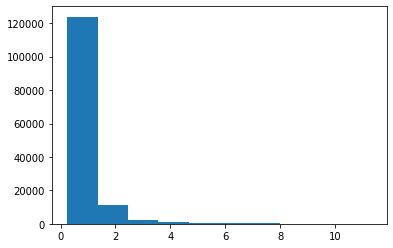

In [2]:
diffs = np.abs(m1_pred-m2_pred).mean(axis=-1)
print(diffs.mean(), diffs.max(), diffs.min(), diffs.std())
plt.figure()
plt.hist(diffs);
del diffs

### Atomic distances

#### Sample atomic models

(10748, 101120, 3)
(101120,) (101120,)


@> WARNING hybrid36 format is being used
@> WARNING hybrid36 format is being used
@> WARNING hybrid36 format is being used


(101120,) 0.35020554 3.061569
(0.009560976425679414, 0.0023629373754647126)


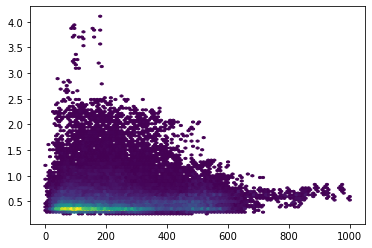

In [3]:
from sklearn.decomposition import PCA
from scipy.stats import iqr, pearsonr
from prody import writePDB

def sampleAtomicPCA(atomic_model, pred_nma, sample=2, sample_frac=0.99):
    pca = PCA(pred_nma.shape[1])
    pca.fit(pred_nma)
    pc = pca.transform(pred_nma)
    sampled_coords = []
    for ii in range(pred_nma.shape[1]):
        s = np.zeros((sample, pred_nma.shape[1]))
        s[:,ii] = np.linspace(np.quantile(pc[:,ii], 1-sample_frac), 
                              np.quantile(pc[:,ii], sample_frac), sample)
        sampled_nma = pca.inverse_transform(s)
        sampled_nma = torch.as_tensor(sampled_nma, dtype=torch.float32)[:, None, :]
        sampled_coords.append(atomic_model(sampled_nma)[0])
    return torch.stack(sampled_coords), pca.explained_variance_ratio_

def sampleAtomicModels(atomic_model, pred_nma, sample=10000):
    N = pred_nma.shape[0]
    sampled_pred = pred_nma[::N//sample]
    sampled_pred = torch.as_tensor(sampled_pred, dtype=torch.float32)[:, None, :]
    return atomic_model(sampled_pred)[0].detach().cpu().numpy()

def writeBFactor(prody_model, quantity, fname):
    ref = prody_model.copy()
    ref.setBetas(quantity)
    writePDB(fname, ref, hybrid36=True)

def euclideanDistance(m1, m2=None):
    return np.linalg.norm(m1 if m2 is None else m1 - m2, axis=-1)

def getDeformationVectors(atomic_model, pred_nma):
    atomic_coords, weights = sampleAtomicPCA(atomic_model, pred_nma, 2)
    atomic_coords = (atomic_coords[:, -1, ...] - atomic_coords[:, 0, ...]).detach().cpu().numpy()
    return  atomic_coords * weights[:, np.newaxis, np.newaxis]
    
m1_atomic_coords = sampleAtomicModels(m1_atomic_model, m1_pred)
m2_atomic_coords = sampleAtomicModels(m2_atomic_model, m2_pred)
full_atomic_coords = sampleAtomicModels(full_atomic_model, full_pred)
print(m2_atomic_coords.shape)
uncertainty = euclideanDistance(m1_atomic_coords, m2_atomic_coords)
motion = euclideanDistance(full_atomic_coords, prody_model.getCoords()).std(axis=0)
uq = uncertainty.mean(axis=0)
par = uq/motion 
print(uq.shape, motion.shape)

writeBFactor(prody_model, uq, "pred_uq.pdb")
writeBFactor(prody_model, par, "pred_par.pdb")
writeBFactor(prody_model, motion, "pred_motion.pdb")

print(uq.shape, uq.min(), uq.max())
print(pearsonr(prody_model.getBetas(), par))

plt.figure()
plt.hexbin(prody_model.getBetas(), par, mincnt=1)